# #SMM4H: Task 4

Prior to running the code, please upload required files to Google Colab

Please use the following cell to install the necassry library needed to run this model. Restart the Kernal, before running the rest of the code.

!! DO NOT RUN AFTER RESTARTING THE KERNEL !!


In [ ]:
!pip install datasets
!pip install transformers
!pip install datasets
!pip install seqeval
!pip install transformers[torch]
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=745e5c1cd648334af7da72a87ae3866a6ca64984189c4c24bd81d75fe0499fec
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built 

#AFTER RESTARTING KERNEL, START RUNNING CODE FROM HERE

## Cleaning the Data

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

NUMBER_OF_POSTS = 848

In [ ]:
# Import the data
clean_data = []
full_data = []
with open("reddit-impacts-train.tsv", "r") as file:
    for line in file:
      if not line.startswith("#Text"):
        clean_data.append(line)
      else:
        full_data.append(line)

In [ ]:
# Create the posts and labels lists
posts = [[] for _ in range(NUMBER_OF_POSTS)]
labels = [[] for _ in range(NUMBER_OF_POSTS)]
for line in clean_data:
  parts = line.split("\t")
  if len(parts) == 6:
    post_number, token_number = parts[0].split("-")
    word = parts[2]
    label = parts[4]
    posts[int(post_number)].append(word)
    labels[int(post_number)].append(label)


The data is already tokenized for us, all we have to do is split the data into training and test.

In [ ]:
# Checking unique values
unique_label = set()
for label in labels:
  for value in label:
    unique_label.add(value)

label_list = []
for label in unique_label:
  label_list.append(label)

print(label_list)

['Social Impacts', 'Clinical Impacts', '_']


In [ ]:
# creating encoding dict
label_encoding_dict = {'_': 0, 'Clinical Impacts': 1, 'Social Impacts': 2}

# Splitting labels and posts into test and train data
from sklearn.model_selection import train_test_split

Xt, Xv, yt, yv = train_test_split(posts, labels, test_size = 0.20, train_size = 0.80)

In [ ]:
from datasets import Dataset

# Create test and train dataset
train_df = pd.DataFrame({'tokens': Xt,
                         'labels': yt})

test_df = pd.DataFrame({'tokens': Xv,
                        'labels': yv})

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)



## Transformers

In [ ]:
# Loading necessary libraries
import os
import itertools
from datasets import load_metric
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
import torch

In [ ]:
# Setting parameters
task = "labels"
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_and_align_labels(examples):
    label_all_tokens = True
    tokenized_inputs = tokenizer(list(examples["tokens"]), truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"{task}"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif label[word_idx] == '0':
                label_ids.append(0)
            elif word_idx != previous_word_idx:
                label_ids.append(label_encoding_dict[label[word_idx]])
            else:
                label_ids.append(label_encoding_dict[label[word_idx]] if label_all_tokens else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


train_tokenized_datasets = train_dataset.map(tokenize_and_align_labels, batched=True)
test_tokenized_datasets = test_dataset.map(tokenize_and_align_labels, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/678 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/170 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))

args = TrainingArguments(
    f"test-{task}",
    evaluation_strategy = "epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=1e-5,
)

data_collator = DataCollatorForTokenClassification(tokenizer)
metric = load_metric("seqeval")


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [[label_list[p] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]
    true_labels = [[label_list[l] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {"precision": results["overall_precision"], "recall": results["overall_recall"], "f1": results["overall_f1"], "accuracy": results["overall_accuracy"]}

trainer = Trainer(
    model,
    args,
    train_dataset=train_tokenized_datasets,
    eval_dataset=test_tokenized_datasets,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()
trainer.save_model('un-ner.model')

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-14-e2371a4b1767>:14: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` 

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.357641,0.847732,0.981520,0.909734,0.851852
2,No log,0.367285,0.869589,0.948665,0.907407,0.863694
3,No log,0.438487,0.870712,0.968026,0.916794,0.874024


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Social Impacts seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Clinical Impacts seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: _ seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Validation

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
import pandas as pd

NUMBER_OF_POSTS_V = 262

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('./un-ner.model/')
model = AutoModelForTokenClassification.from_pretrained('./un-ner.model/', num_labels=len(label_list))

clean_data_test =[]
full_data_test = []
# read in testing data
with open("reddit-impacts-dev.tsv", "r") as file:
    for line in file:
      if not line.startswith("#Text"):
        clean_data_test.append(line)
      else:
        full_data_test.append(line)

paragraph = [[] for _ in range(NUMBER_OF_POSTS_V)]
index = [[] for _ in range(NUMBER_OF_POSTS_V)]
span = [[] for _ in range(NUMBER_OF_POSTS_V)]
labels_v = [[] for _ in range(NUMBER_OF_POSTS_V)]
for line in clean_data_test:
  parts = line.split("\t")
  if len(parts) == 6:
    post_number, token_number = parts[0].split("-")
    ind = parts[0]
    sp = parts[1]
    word = parts[2]
    label = parts[4]
    paragraph[int(post_number)].append(word)
    index[int(post_number)].append(ind)
    span[int(post_number)].append(sp)
    labels_v[int(post_number)].append(label)

In [ ]:
# Predict labels for each token in paragraph
output_lines = []
prediction_label = []
for i, post_tokens in enumerate(paragraph):
    # Tokenize the post
    inputs = tokenizer(" ".join(post_tokens), return_tensors="pt")
    # Perform token classification
    with torch.no_grad():
        outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=2)[0].tolist()  # Get predicted labels

    # Format output
    post_prediction_label = []
    post_text = " ".join(post_tokens)
    output_lines.append(f"#Text = {post_text}")
    for j, (token, pred_label_id) in enumerate(zip(post_tokens, predictions)):
        pred_label = label_list[pred_label_id] if pred_label_id != 0 else "_"
        has_label = "*" if pred_label_id != 0 else "_"
        # Access index and span for the current post
        current_index = index[i][j]
        current_span = span[i][j]
        output_lines.append(f"{current_index}\t{current_span}\t{token}\t{has_label}\t{pred_label}")
        post_prediction_label.append(pred_label)
    prediction_label.append(post_prediction_label)
    output_lines.append("")

# Write output to TSV file
with open("output.tsv", "w") as file:
    for line in output_lines:
        file.write(line + "\n")

In [ ]:
import csv
# Prepare the data for writing to CSV
def flatten_list_of_lists(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

flat_predictions = flatten_list_of_lists(prediction_label)
flat_labels = flatten_list_of_lists(labels_v)

def write_csv(predictions, labels, filename):
    with open(filename, 'w', newline='') as csvfile:
        fieldnames = ['Labels', 'Predictions']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for label, prediction in zip(labels, predictions):
            writer.writerow({'Labels': label, 'Predictions': prediction})

filename = 'predictions_labels.csv'
write_csv(flat_predictions, flat_labels, filename)

Precision: 0.8908045977011494
Recall: 0.8908045977011494
Accuracy: 0.8908045977011494
F1 Score: 0.8908045977011495


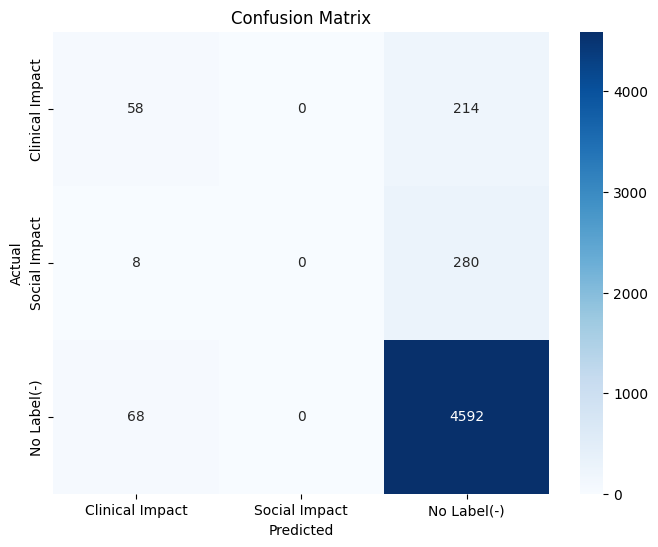

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


precision = precision_score(flat_labels, flat_predictions, average='micro')
recall = recall_score(flat_labels, flat_predictions, average='micro')
accuracy = accuracy_score(flat_labels, flat_predictions)
f1 = f1_score(flat_labels, flat_predictions, average='micro')

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1)

# Calculate confusion matrix
cm = confusion_matrix(flat_labels, flat_predictions)

# Plot confusion matrix
plot_confusion_matrix(cm, labels=["Clinical Impact", "Social Impact", "No Label(-)"])


##Test

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
import pandas as pd

NUMBER_OF_POSTS_T = 280

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('./un-ner.model/')
model = AutoModelForTokenClassification.from_pretrained('./un-ner.model/', num_labels=len(label_list))

c_data_test =[]
f_data_test = []
# read in testing data
with open("reddit-impacts-test-nolabel.tsv", "r") as file:
    for line in file:
      if not line.startswith("#Text"):
        c_data_test.append(line)
      else:
        f_data_test.append(line)

paragraph_test = [[] for _ in range(NUMBER_OF_POSTS_T)]
index_test = [[] for _ in range(NUMBER_OF_POSTS_T)]
span_test = [[] for _ in range(NUMBER_OF_POSTS_T)]
for line in c_data_test:
  parts = line.split("\t")
  if len(parts) >= 5:
    post_number, token_number = parts[0].split("-")
    ind = parts[0]
    sp = parts[1]
    word = parts[2]
    paragraph_test[int(post_number)].append(word)
    index_test[int(post_number)].append(ind)
    span_test[int(post_number)].append(sp)

In [ ]:
# Predict labels for each token in paragraph
output_lines = []
for i, post_tokens in enumerate(paragraph_test):
    # Tokenize the post
    inputs = tokenizer(" ".join(post_tokens), return_tensors="pt")
    # Perform token classification
    with torch.no_grad():
        outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=2)[0].tolist()  # Get predicted labels

    # Format output
    post_text = " ".join(post_tokens)
    output_lines.append(f"#Text = {post_text}")
    for j, (token, pred_label_id) in enumerate(zip(post_tokens, predictions)):
        pred_label = label_list[pred_label_id] if pred_label_id != 0 else "_"
        has_label = "*" if pred_label_id != 0 else "_"
        # Access index and span for the current post
        current_index = index_test[i][j]
        current_span = span_test[i][j]
        output_lines.append(f"{current_index}\t{current_span}\t{token}\t{has_label}\t{pred_label}")
    output_lines.append("")

# Write output to TSV file
with open("answer.tsv", "w") as file:
    for line in output_lines:
        file.write(line + "\n")